In [1]:
using DrWatson

In [2]:
include(srcdir("rdpg.jl"))
import Main.rdpg
using LinearAlgebra, Pipe, Plots, ProgressMeter, Statistics, StatsBase, Suppressor
using Clustering, Distances, Distributions, Ripserer

theme(:default)

### Latent Space

Latent space consists of $n=1200$ points sampled from two concentric circles, i.e. $\mathbb{X} = \partial B(0, 0.5) \cup \partial B(0, 0.9)$ with labels 
$$
\text{label}(\boldsymbol{x}) = \begin{cases}
0 & \text{  if }\boldsymbol{x} \in \partial B(0, 0.9)\\
1 & \text{  if }\boldsymbol{x} \in \partial B(0, 0.5)
\end{cases}
$$

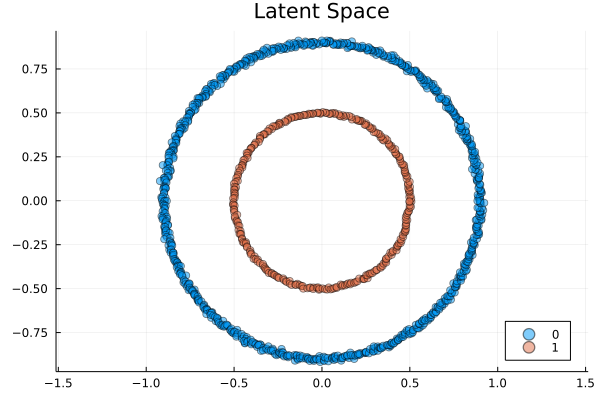

In [3]:
n = 300;

Z1 = map(x -> x .* 0.9, rdpg.randCircle(3n, s=0.01))
Z2 = map(x -> x .* 0.5, rdpg.randCircle( n, s=0.01))
Z = [Z1; Z2]
labels = [repeat([0], length(Z1)); repeat([1], length(Z2))]

plt0 = @pipe Z |> scatter(_, group=labels, aspect_ratio = :equal, title = "Latent Space", legend=:bottomright, ma=0.5)

The adjacency matrix $A \sim \text{gRDPG}(\mathbb P, \mathbb X_n)$

In [4]:
f = (x, y) -> abs.((dot([x...], [y...])))
A = rdpg.Adjacency(f, Z);

The spectral embedding $\widehat{\mathbb{X}}_n = \textsf{spectral}(A)$ is illustrated below. 

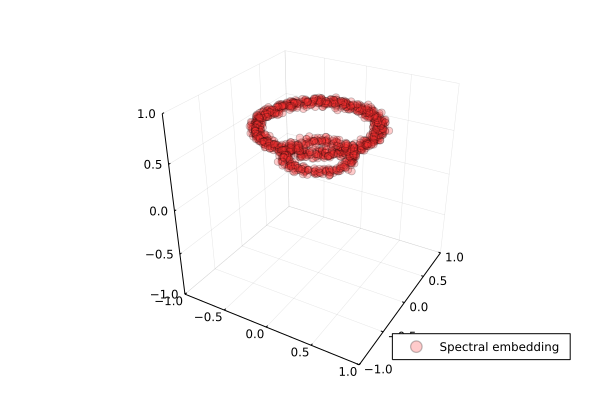

In [5]:
X, _ = rdpg.spectralEmbed(A, scale = false, d = 3)
plt1 = @pipe X |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, c=:firebrick1, label="Spectral embedding", legend=:bottomright, lim=(-1,1), ma=0.25)

For $\epsilon=2$, the $\epsilon-$ differentially private graph $B = \mathcal{M}_{\epsilon}(A)$, and the privacy-adjusted spectral embedding $\widehat{\mathbb{Y}}_n = \mathsf{spectral} \circ \mathcal{M}^{\star}_{\epsilon}(B)$ are below. 

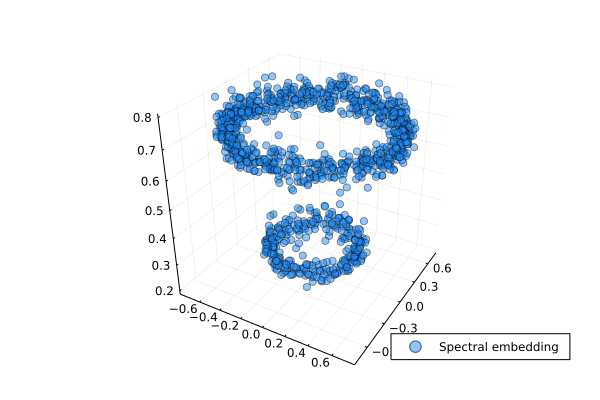

In [6]:
ϵ = 2
B = rdpg.edgeFlip(A; ϵ = 2)
Y, _ = @pipe B  |> (_ .- (rdpg.τ(ϵ)^2)) ./ (rdpg.σ(ϵ)^2) |> rdpg.spectralEmbed(_; d = 3, scale = false)
plt2 = @pipe Y |> rdpg._Matrix_to_ArrayOfTuples |> scatter(_, c = :dodgerblue, label = "Spectral embedding", legend = :bottomright, ma=0.5)

### $k-$ Means clustering under differential privacy
----

Ordinarily, $k-$ Means clustering requires a tuning parameter $k$ specifying the number of clusters. We assume that the number of clusters $k=2$ is known *a priori*, and we perform clustering on the spectral embedding. The results are below. 

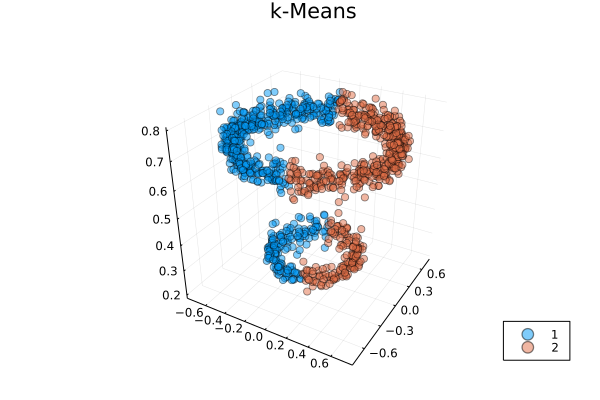

In [7]:
kmeans_labels = Clustering.kmeans(Y', 2).assignments
kmeans_plt = scatter(Y |> rdpg._Matrix_to_ArrayOfTuples, group = kmeans_labels, legend = :bottomright, title = "k-Means", ma=0.5)

The results shown above are selecting the best clustering candidate based on $N=25$ random initializations based on the clustering silhouettes. Instead, we could also cluster based on the lowest misclassification error (assuming the true labels are also known a priori). The best result from $N=25$ random initilizations are shown below. 

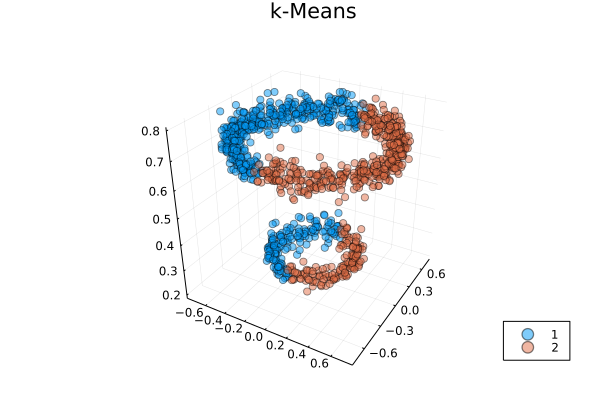

In [8]:
function oracle_cluster_embeddings(X, d, labels)
    iter = 25
    best = -1
    clusters = nothing
    for i = 1:iter
        res = Clustering.kmeans(X', d)
        metric = mean(res.assignments .== labels)
        if metric > best
            best = metric
            clusters = res.assignments
        end
    end
    return clusters
end

kmeans_labels_alt = oracle_cluster_embeddings(X, 2, labels);
kmeans_plt2 = scatter(Y |> rdpg._Matrix_to_ArrayOfTuples, group = kmeans_labels_alt, legend = :bottomright, title = "k-Means", ma=0.5)

### Topology-aware clustering
----

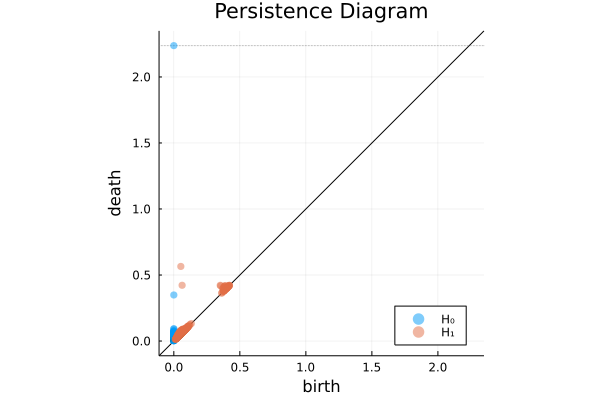

In [9]:
D = @pipe Y |> rdpg.m2t |> ripserer(Alpha(_), dim_max = 1, reps = true, alg=:involuted)
dgmplot =  plot(D)
@suppress display(dgmplot)

[Chazal et al. (2013)](https://dblp.org/rec/journals/jacm/ChazalGOS13.html) proposed ToMATo clustering as an algorithm to overcome the drawbacks of $k-$ means clustering by forming clusters based on topological persistence. However, their methodology (Algorithm 1) requires the following tuning parameters: (1) A Kernel $\mathcal{K}(\cdot, \cdot)$ with bandwidth $\sigma$ density filtering, (2) the cutoff level $\tau$ of the density filtration, and (3) the resolution $\delta$ for the Rips complex. 

While their method is useful for robust clustering in the presence of outliers; we note that under differential privacy, from Propositions 3.3 and 3.4, no extraneous outliers are introduced. Therefore, we *propose the following simple clustering algorithm* inspired by ToMATo, which requires just one tuning parameter $q$.

#### Algorithm: Topology-Aware Clustering

* **Input:** Points $\mathbb{X}_n$ and a cutoff quantile $q$

1. Compute the persistence diagram $\mathfrak{D} = \mathfrak{Dgm}(\mathbb{X}_n)$
2. For all $i \in |\mathfrak{D}|$ **do**
    * Compute the total persistence $\Delta_i = |{b_i - d_i}|$ for the birth/death pair $(b_i, d_i) \in \mathfrak{D}$ 
    
    **end for**


3. Compute the median $m(\Delta)$ and the mean-absolute-deviation $\varsigma(\Delta)$ for the collection $\Delta = \{ \Delta_i : i \in |\mathfrak{D}| \}$
4. Initialize $\textsf{Clusters} = \varnothing$
5. For all $i \in |\mathfrak{D}|$ **do**
    * Compute the standardized score $\bar{\Delta}_i = |\Delta_i - m(\Delta)| / \varsigma(\Delta)$ for the birth/death pair $(b_i, d_i) \in \mathfrak{D}$ 
    
    * **If** $\bar{\Delta}_i > q$ 
        * Filter the simplex $\sigma$ with $(\text{birth}(\sigma), \text{death}(\sigma)) = \{(b_i, d_i)\}$

        * Extract the vertices of $V(\sigma) = \{\boldsymbol{x} : \boldsymbol{x} \in \sigma\}$
        
        * $\textsf{Clusters} = \textsf{Clusters} \bigcup \{V(\sigma)\}$
        
        **end if**
    
    **end for**

6. ***Return*** $\textsf{Clusters}$

In [10]:
function stdscore(w)
    return [abs(x - mean(w)) / std(w) for x in w]
end;

Taking q = 3, we may filter the relevant points in the persistence diagram. The filtered points in the $0^{th}-$ order persistence diagram are as follows:

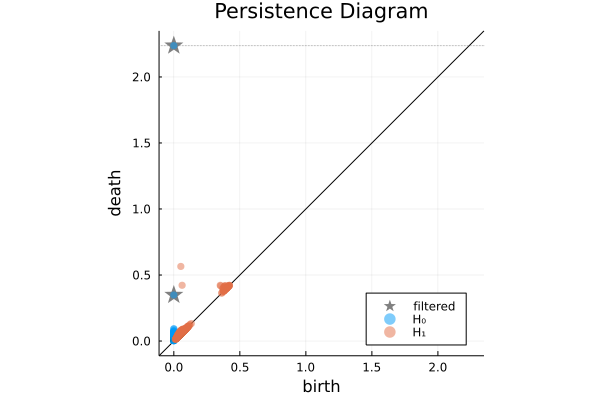

In [11]:
q = 3
order = 1 # order = dim + 1
u1 = Ripserer.persistence.(D[order][1:end-1])
v1 = [0, u1[1:end-1]...]
w1 = u1 - v1
index1 = findall(x -> x > q, stdscore(w1))

plot(D[order][[index1; end]], mc=:grey, ma=1, shape=:star5, ms=10, label="filtered")
plot!(D)

Similarly, the filtered points in the $1^{st}-$ order persistence diagram are as follows:

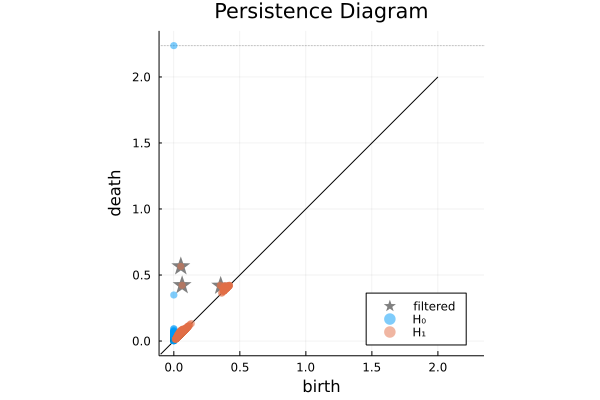

In [12]:
order = 2 # order = dim - 1
u2 = Ripserer.persistence.(D[order][1:end])
v2 = [0, u2[1:end-1]...]
w2 = u2 - v2
index2 = findall(x -> x > q, stdscore(w2))
plot(D[order][index2], lim=(-0.1, 2), label="filtered", markercolor=:grey, markeralpha=1, shape=:star, markersize=10)
plot!(D)

The representative cycles are illustrated below.

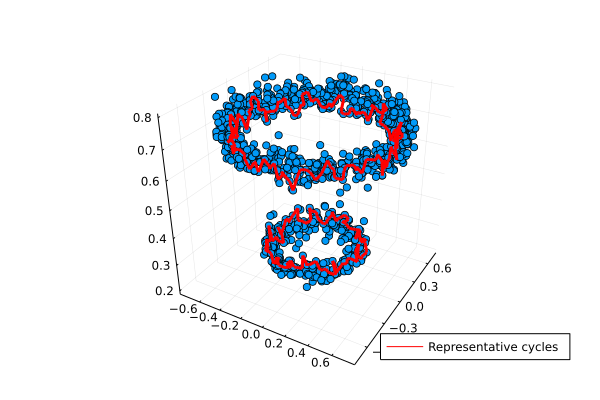

In [13]:
points = Y |> rdpg.m2t
scatter(points, label=nothing, legend=:bottomright)
plot!(D[2][end-1], points, label="Representative cycles", c=:red, lw=3, ma=0.2)

We can use filtered points in the persistence diagram to cluster the points using the **Topology-aware clustering algorithm**.

In [14]:
function extract_vertices(d, f = Ripserer.representative)
    return @pipe d |> f .|> Ripserer.vertices |> map(x -> [x...], _) |> rdpg.t2m |> unique
end;

function filterDgm(dgm; order = 1, ς=3, f = Ripserer.representative, vertex=true)

    thresh = threshold(dgm[order])
    
    if order == 1
        u = Ripserer.persistence.(dgm[order][1:end-1])
        # u = replace(x -> x == Inf ? thresh : x, Ripserer.persistence.(dgm[order][1:end-1]))
    
        v = [0, u[1:end-1]...]
    else
        u = Ripserer.persistence.(dgm[order][1:end])
        # u = replace(x -> x == Inf ? thresh : x, Ripserer.persistence.(dgm[order][1:end-1]))
        v = [0, u[1:end-1]...]
    end

    w = u - v
    index = findall(x -> x > ς , stdscore(w))
    return vertex ? [extract_vertices(dgm[order][i...], f) for i in index] : index
end;

function dgmclust(dgm; order=1, threshold=3)
    idx = filterDgm(dgm, order = order, ς=threshold)
    classes = zeros(Int, eachindex(dgm[1]))
    for k in eachindex(idx)
        classes[idx[k]] .= k
    end
    return classes
end

dgmclust (generic function with 1 method)

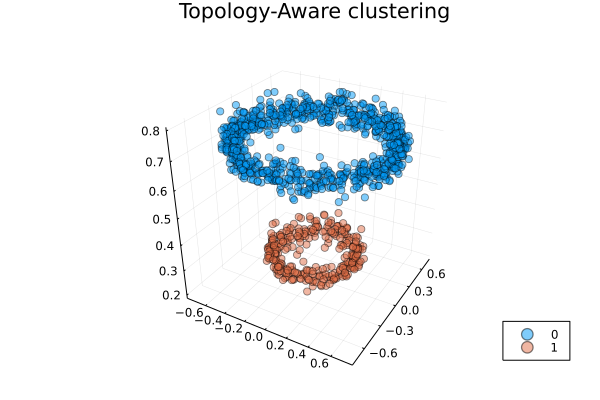

In [15]:
topological_clusters = dgmclust(D, order=1, threshold=2)
topological_plot = scatter(Y |> rdpg._Matrix_to_ArrayOfTuples, group=topological_clusters, legend=:bottomright, title="Topology-Aware clustering", ma=0.5)
@suppress display(topological_plot)

----

In [16]:
function one_simulation(eps; latent=:circles)
    n = 350

    if latent == :circles
        
        K = 2
        
        Z = [map(x -> x .* 0.5 .* i, rdpg.randCircle(i * n, s=0.05)) for i in 1:K]
        labels = vcat([ones(Int, length(Z[i])) .* i for i in 1:K]...)
        Z = vcat(Z...)        
        indx = sample(eachindex(Z), length(Z), replace=false)
        Z = Z[indx]
        labels = labels[indx]
        
        N = length(Z)
        f = (x, y) -> abs.((dot([x...], [y...]))) .* log(N) / (N^(1/3))
        A = rdpg.Adjacency(f, Z);
    
    elseif latent == :sbm
        
        K = 3
        N = K * n
        
        r, p, k = 0.15, 0.15, K
        
        f = (x, y) -> (r + p * (x == y)) .* log(N) / (N^(1/3))
        labels = rand(1:k, 4n)
        A = rdpg.Adjacency(f, labels)
                
    end
    
    B = rdpg.edgeFlip(A; ϵ = eps)
    Y, _ = @pipe B  |> (_ .- (rdpg.τ(eps)^2)) ./ (rdpg.σ(eps)^2) |> rdpg.spectralEmbed(_; d = 3, scale = false, restarts=10000)
    D = ripserer(Y |> rdpg.m2t |> Alpha, dim_max=0, reps = true, alg=:involuted)
    
    kclusts = Clustering.kmeans(Y', K).assignments # rdpg.cluster_embeddings(Y, K)
    tclusts = dgmclust(D, threshold=3)

    return (labels, kclusts, tclusts)
end

evaluate(X, Y, f1, f2) = f2.(eachrow(map((x, y) -> f1(Int.(x), Int.(y)), Y, X)))
randindx(x, y) = randindex(x, y)[2]

randindx (generic function with 1 method)

In [17]:
eps = 10 .^ [-2.0:1.0:2.0...]
m = length(eps)
repeats = 30

30

In [ ]:
labels = repeat([Any[]], m, repeats)
top    = repeat([Any[]], m, repeats)
kmeans = repeat([Any[]], m, repeats)

prog = ProgressMeter.Progress(m * repeats)

for (e, i) in zip(eps, eachindex(eps)), j in 1:repeats
    res = one_simulation(e; latent=:circles)
    labels[i, j] = res[1]
    kmeans[i, j] = res[2]
    top[i, j]    = res[3]
    next!(prog)
end

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:34

In [ ]:
ev(X, f) = evaluate(X, labels, mutualinfo, f)
plt_c_mutual = plot(x -> 1e-1, eps, ma=0, la=0, label="Two-Circles", yaxis="Mutual Information", xaxis="ϵ", legend=:bottomright, yticks=0.1:0.1:1.00)
plot!(eps, ev(kmeans, mean), ribbon=0.5 .* ev(kmeans, std), m=:o, xscale=:log10, label="k-Means")
plot!(eps, ev(top, mean), ribbon=0.5 .* ev(top, std), m=:o, xscale=:log10, label="Topological")

In [20]:
labels_sbm = repeat([Any[]], m, repeats)
top_sbm    = repeat([Any[]], m, repeats)
kmeans_sbm = repeat([Any[]], m, repeats)

prog = ProgressMeter.Progress(m * repeats)

for (e, i) in zip(eps, eachindex(eps)), j in 1:repeats
    res = one_simulation(e; latent=:sbm)
    labels_sbm[i, j] = res[1]
    kmeans_sbm[i, j] = res[2]
    top_sbm[i, j]    = res[3]
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:48


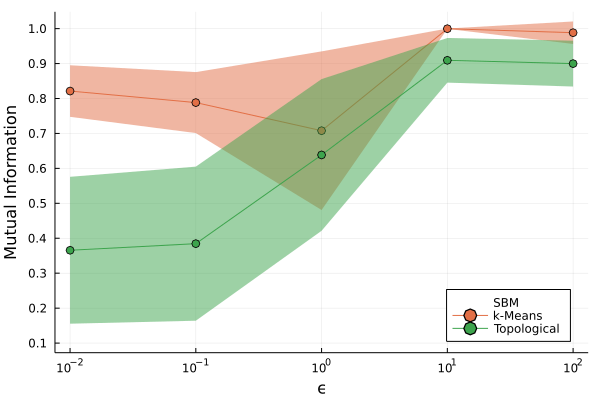

In [21]:
ev(X, f) = evaluate(X, labels_sbm, mutualinfo, f)
plt_s_mutual = plot(x -> 1e-1, eps, ma=0, la=0, label="SBM", yaxis="Mutual Information", xaxis="ϵ", legend=:bottomright, yticks=0.1:0.1:1.1)
plot!(eps, ev(kmeans_sbm, mean), ribbon=0.5 .* ev(kmeans_sbm, std), m=:o, xscale=:log10, label="k-Means")
plot!(eps, ev(top_sbm, mean), ribbon=0.5 .* ev(top_sbm, std), m=:o, xscale=:log10, label="Topological")